In [1]:
from __future__ import print_function, division
%matplotlib inline


import os

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError: 
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import theano
print("Theano version:",theano.__version__)
import sys
print (sys.version)
import h5py

Theano version: 1.0.2
2.7.15 |Anaconda, Inc.| (default, May  1 2018, 23:32:55) 
[GCC 7.2.0]


Using cuDNN version 7001 on context None
Mapped name None to device cuda0: GeForce GTX TITAN X (0000:08:00.0)


dataDir = "/home/ktian/kundajelab/tfnet/ENCODE_data/"

5 tasks:
/home/ktian/kundajelab/tfnet/ENCODE_data/A549-SIX5-human-ENCSR000BRL-optimal_idr.narrowPeak.gz
/home/ktian/kundajelab/tfnet/ENCODE_data/GM12878-SIX5-human-ENCSR000BJE-optimal_idr.narrowPeak.gz
/home/ktian/kundajelab/tfnet/ENCODE_data/H1-hESC-SIX5-human-ENCSR000BIQ-optimal_idr.narrowPeak.gz
/home/ktian/kundajelab/tfnet/ENCODE_data/K562-SIX5-human-ENCSR000BGX-optimal_idr.narrowPeak.gz
/home/ktian/kundajelab/tfnet/ENCODE_data/K562-SIX5-human-ENCSR000BNW-optimal_idr.narrowPeak.gz

Metaclusters heatmap


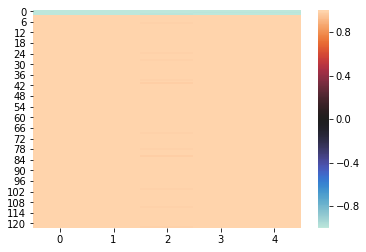

metacluster_0
activity pattern: [1 1 0 1 1]
metacluster_0 pattern_0
total seqlets: 102
Task 0 hypothetical scores:


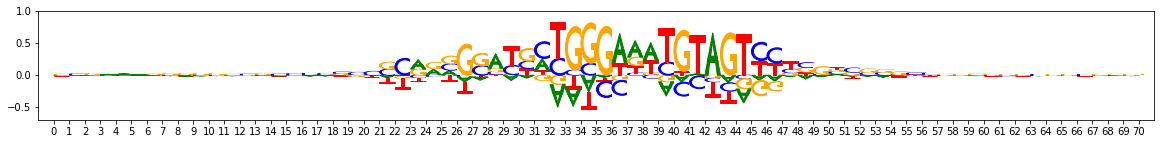

Task 0 actual importance scores:


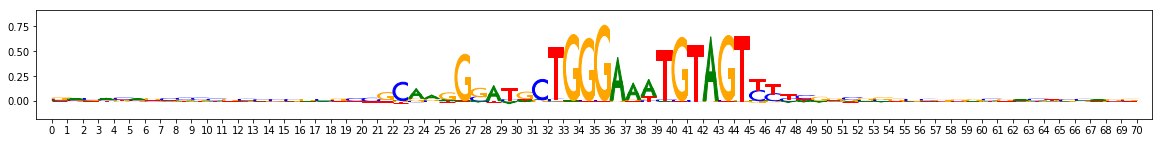

Task 1 hypothetical scores:


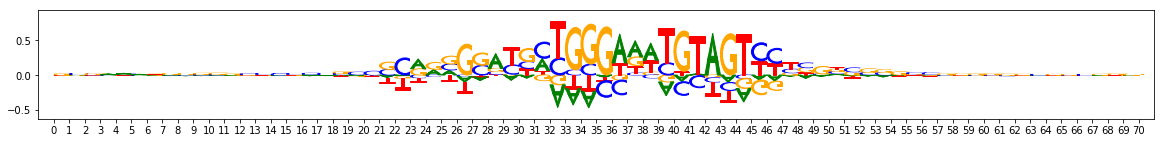

Task 1 actual importance scores:


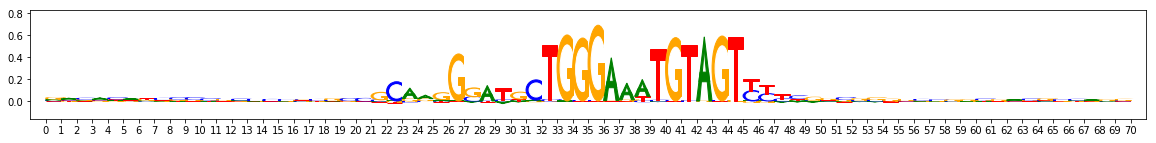

Task 2 hypothetical scores:


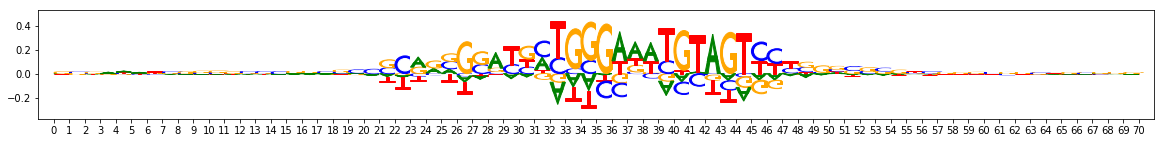

Task 2 actual importance scores:


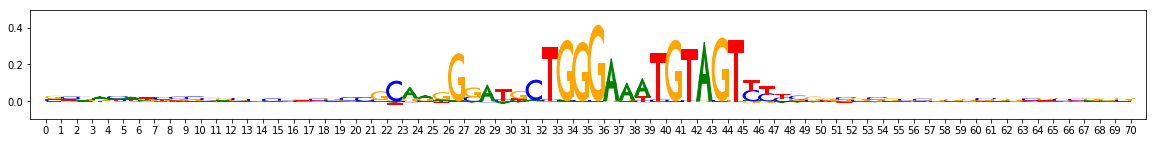

Task 3 hypothetical scores:


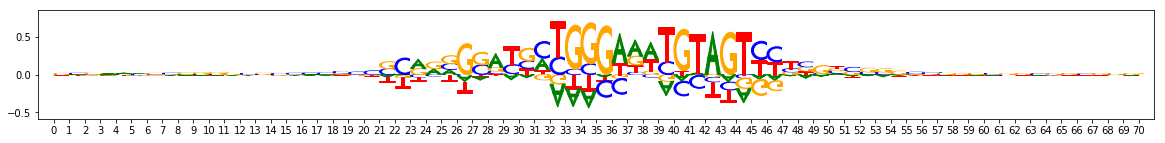

Task 3 actual importance scores:


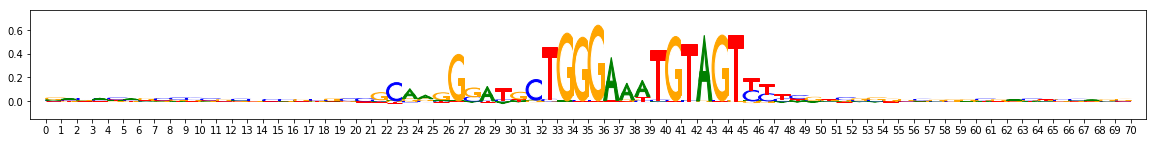

Task 4 hypothetical scores:


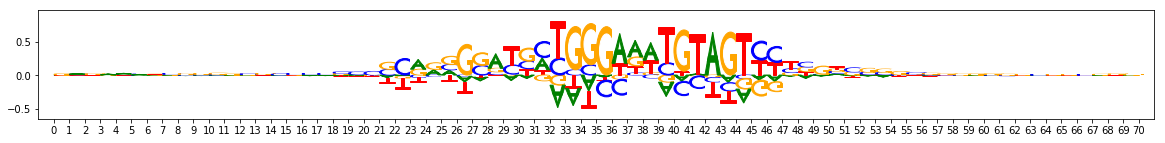

Task 4 actual importance scores:


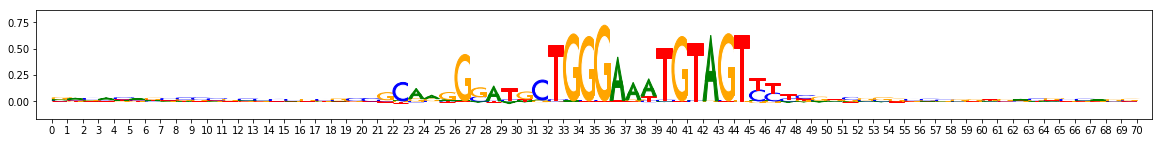

onehot, fwd and rev:


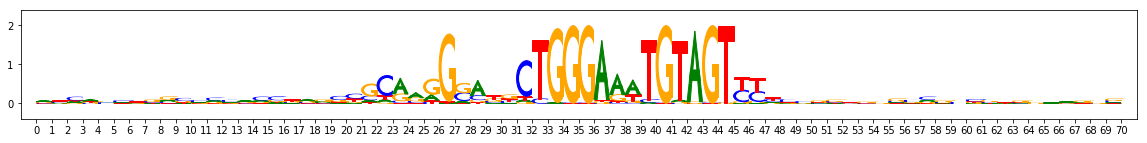

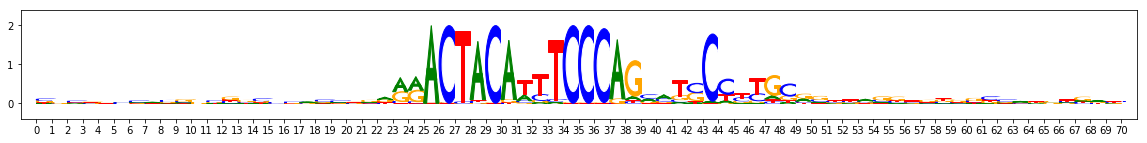

In [3]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("Task 1 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"]["fwd"])
        print("Task 1 actual importance scores:")
        viz_sequence.plot_weights(pattern["task1_contrib_scores"]["fwd"])
        print("Task 2 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"]["fwd"])
        print("Task 2 actual importance scores:")
        viz_sequence.plot_weights(pattern["task2_contrib_scores"]["fwd"])
        print("Task 3 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task3_hypothetical_contribs"]["fwd"])
        print("Task 3 actual importance scores:")
        viz_sequence.plot_weights(pattern["task3_contrib_scores"]["fwd"])
        print("Task 4 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task4_hypothetical_contribs"]["fwd"])
        print("Task 4 actual importance scores:")
        viz_sequence.plot_weights(pattern["task4_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        
hdf5_results.close()

In [4]:
import scipy.stats
import h5py

hdf5_results = h5py.File("results.hdf5","r")

patterns_to_compare = [
    [("metacluster_1", "pattern_0"), ("metacluster_3", "pattern_0")]
]

for ((pattern1_metacluster, pattern1_name),
     (pattern2_metacluster, pattern2_name)) in patterns_to_compare:
    
    print("Comparing "+pattern1_metacluster+"_"+pattern1_name
          +" and "+pattern2_metacluster+"_"+pattern2_name)
    
    pattern1_seqlets = list(hdf5_results["metacluster_idx_to_submetacluster_results"]\
                                             [pattern1_metacluster]["seqlets_to_patterns_result"]\
                                             ["patterns"][pattern1_name]["seqlets_and_alnmts"]["seqlets"])
    pattern1_example_idxs = set([
        x.decode("utf-8").split(",")[0].split(":")[1] for x in
        pattern1_seqlets])

    pattern2_seqlets = list(hdf5_results["metacluster_idx_to_submetacluster_results"]\
                                         [pattern2_metacluster]["seqlets_to_patterns_result"]\
                                         ["patterns"][pattern2_name]["seqlets_and_alnmts"]["seqlets"])
    pattern2_example_idxs = set([
        x.decode("utf-8").split(",")[0].split(":")[1] for x in
        pattern2_seqlets])

    for (comparison_pattern_metacluster,
         comparison_pattern_name) in all_patterns:
        
        if ((comparison_pattern_metacluster+"_"+comparison_pattern_name
             != pattern1_metacluster+"_"+pattern1_name)
            and (comparison_pattern_metacluster+"_"+comparison_pattern_name
             != pattern2_metacluster+"_"+pattern2_name)):
            
            comparison_pattern_seqlets = list(
                hdf5_results["metacluster_idx_to_submetacluster_results"]\
                [comparison_pattern_metacluster]["seqlets_to_patterns_result"]\
                ["patterns"][comparison_pattern_name]["seqlets_and_alnmts"]["seqlets"])
            comparison_pattern_example_idxs = set([
                x.decode("utf-8").split(",")[0].split(":")[1] for x in
                comparison_pattern_seqlets])
        
            
            pattern1_overlap = len(pattern1_example_idxs.intersection(
                                    comparison_pattern_example_idxs))
            pattern2_overlap = len(pattern2_example_idxs.intersection(
                                    comparison_pattern_example_idxs))
            
            contingency_table = np.array([
                [pattern1_overlap, len(pattern1_example_idxs)-pattern1_overlap],
                [pattern2_overlap, len(pattern2_example_idxs)-pattern2_overlap]])
            odds_ratio, p_value = scipy.stats.fisher_exact(contingency_table)
            print("Looking at enrichment for "+comparison_pattern_metacluster
                                              +"_"+comparison_pattern_name)
            print("Odds ratio:",odds_ratio,
                      "P-value:",p_value)
        

            
hdf5_results.close()

Comparing metacluster_1_pattern_0 and metacluster_3_pattern_0


KeyError: "Unable to open object (object 'metacluster_1' doesn't exist)"